# 10-5-3 network decay tests

In [1]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
%aimport NeuralNetwork
%aimport Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy
importlib.reload(NN)
importlib.reload(Layer);

In [2]:
def ClassPlot(x, labels=[], idx=(1,2)):
    # FeedForward
    #yc = Network.OneHot(y)
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    plt.axis('equal');

## Create a simple dataset

In [3]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 29561
torch.manual_seed(seed)
np.random.seed(seed)
B = np.eye(n_classes)
X = 3.*(np.random.rand(sensory_dim, n_classes) - 0.5)
A = X.T
print('Bottom vectors')
print(B)
print('Top vectors')
print(A)
#print('System matrix:\n'+str(M))

Bottom vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Top vectors
[[-0.34431496 -1.30261288  1.2664801  -1.2608779  -1.26086995 -1.00836156
   1.45235195 -1.22394346 -0.99684213  1.28417736]
 [ 0.20152066  1.28678059  0.14688571 -1.40900523 -0.59592629 -0.05049101
  -0.10055794  1.18624446  0.14322608  0.63868269]
 [-0.4448297   1.05952716  0.23670284  0.09324312  0.14226337 -0.28313644
   0.10735313 -0.58312719 -0.89823956 -0.85881006]]


In [4]:
# Use A and B to make a dataset
n_classes, top_dim = np.shape(A)
bottom_dim = n_classes

training_samples = 500
noise = 0.2
training_input = []
training_output = []
for n in range(training_samples):
    r = np.random.randint(n_classes)
    training_input.append(B[r])
    training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)
train = [training_input, training_output]

In [5]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

In [6]:
train = MakeDataset(A, B)

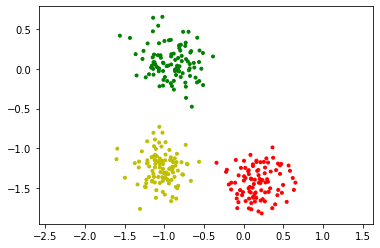

In [7]:
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=(8,3))

## Create a Neural Network

In [14]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=n_classes))
net.AddLayer(Layer.PELayer(n=hidden_dim))
net.AddLayer(Layer.TopPELayer(n=sensory_dim))

sym = False
af = 'identity'
net.Connect(0, 1, act=af, symmetric=sym)
net.Connect(1, 2, act=af, symmetric=sym)

net.SetTau(0.2)
net.learning_tau = 0.08
net.learn_biases = False

identity
identity


## Train it on the dataset

In [15]:
net0 = deepcopy(net)

net0.SetWeightDecay(0.05)
net0.SetvDecay(0.05)
#net0.Learn(torch.tensor(train[0]).float().to(device), torch.tensor(train[1]).float().to(device), T=5., dt=0.001, epochs=10, batch_size=25)
net0.Learn(train[0], train[1], T=4., dt=0.001, epochs=4, batch_size=50, turn_down_lam=0.2)

FloatProgress(value=0.0, max=1200.0)

turning down weight-decay and v-decay by a factor of 0.2
turning down weight-decay and v-decay by a factor of 0.2
turning down weight-decay and v-decay by a factor of 0.2
turning down weight-decay and v-decay by a factor of 0.2


In [16]:
net0.layers[1].v_decay

tensor(8.0000e-05)

### Save it if you want

In [ ]:
net0.Save('no_decay.npy')

### Or load one

In [ ]:
net10 = NN.NeuralNetwork()
net10.Load('no_decay.npy')

In [ ]:
net10.layers[0].v

In [ ]:
net0 = NN.NeuralNetwork()
net0.Load('no_decay.npy')

## Test how well it classifies

In [17]:
# In the backwards nomenclature, "Generate" is the feedforward direction.
mu0 = net0.Generate(5., train[1], dt=0.001)

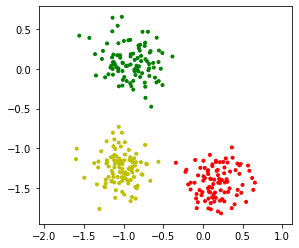

In [18]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1); ClassPlot(train[1], labels=mu0, idx=(8,3))

In [19]:
net0.layers[0].v

tensor([[ 7.7727e-03,  1.2222e-01,  8.1533e-01],
        [ 7.1993e-02,  8.0519e-01, -1.9598e-01],
        [ 1.0618e-01,  9.3353e-01,  1.3273e-01],
        [ 8.5644e-01, -1.9755e-02,  1.8190e-01],
        [ 8.4613e-01,  1.3914e-02,  2.1033e-01],
        [ 9.2384e-01,  1.1865e-02,  9.3390e-02],
        [ 4.7767e-02,  8.3313e-01,  1.5981e-01],
        [ 1.1689e-02,  1.6405e-01,  9.8210e-01],
        [ 1.1179e-01, -6.4037e-03,  7.5013e-01],
        [ 1.6701e-02, -1.0065e-01,  7.4111e-01],
        [ 8.7123e-01,  1.4020e-01,  2.7926e-01],
        [-1.1587e-02,  4.4142e-02,  7.2426e-01],
        [ 4.4947e-03, -3.5229e-03,  7.4006e-01],
        [-2.5160e-02,  9.6630e-01, -3.3046e-02],
        [ 4.8989e-02,  8.6511e-01,  9.6170e-02],
        [ 9.6780e-01, -6.6455e-03, -4.3689e-02],
        [ 8.5835e-01,  9.0383e-02,  6.5665e-03],
        [-3.2051e-02,  8.3421e-01, -7.8347e-03],
        [ 8.5958e-01,  7.7446e-02,  4.9135e-02],
        [ 9.1702e-01, -3.5696e-02, -1.2119e-02],
        [ 8.0674e-01

In [ ]:
net0.dataset_accuracy(train[1], train[0], len(train[0]))

In [ ]:
net0.layers[1].e